Explorando sesgo-varianza a través de validación cruzada repetida y boxplot

In [16]:
# analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set_style('darkgrid')
np.set_printoptions(precision=3)
warnings.filterwarnings("ignore")

# missings (imputer)
# from sklearn.impute import SimpleImputer, KNNImputer

# interacciones
from sklearn.preprocessing import PolynomialFeatures

# transformaciones
from sklearn.compose import ColumnTransformer
# - variab numéricas
from sklearn.preprocessing import RobustScaler # MinMaxScaler, StandardScaler, Normalizer, Binarizer 
# from sklearn.preprocessing import PowerTransformer, BoxCox
# - variab categ
from sklearn.preprocessing import OneHotEncoder # LabelEncoder, OrdinalEncoder

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --
# SELECCIÓN DE VARIABLES:
# PCA
# from sklearn.decomposition import PCA

# a) filters
from sklearn.feature_selection import f_classif # chi2

# b) wrappers
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import RFE, RFECV

# mlxtend forward & backward
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# (estimators for importance score)
from sklearn.linear_model import LogisticRegression
#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --

# algoritmos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier # red neuronal

# bagging
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier

# boosting
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# import xgboost as xgb

# model selection
# from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.pipeline import Pipeline # make_pipeline
from sklearn.model_selection import GridSearchCV # RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict, ParameterGrid

# técnicas de evaluación
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, RocCurveDisplay

In [17]:
# semilla de aleatorización

seed = 99

Recuerda: en este notebook, los datos cargados son diferentes, "datos_fs"

In [18]:
# Cargar los datos
data = pd.read_csv('Datasets/datos_fs.csv')

print(f'Número de filas: {data.shape[0]}, Númerode columnas:{data.shape[1]}')
data.head()

Número de filas: 4687, Númerode columnas:8


,scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log,encoder__Orbit Uncertainity (categ)_1-2,scaler__Est Dia in M(max)_raiz2,scaler__Perihelion Distance scaler__Mean Motion_cuarta,scaler__Est Dia in M(max) scaler__Est Dia in M(max)_raiz2,scaler__Minimum Orbit Intersection,Dataset,Hazardous
0,0.140380,0.0,0.805003,0.029672,0.875189,0.137601,train,0
1,-0.009837,0.0,-0.194176,-0.052661,0.033127,0.056834,train,0
2,0.021498,0.0,0.099947,0.002052,0.010164,0.247025,train,0
3,0.258344,1.0,0.393730,-1.099622,0.179251,1.016807,train,0
4,0.710773,1.0,1.029155,0.094209,1.542575,0.756381,train,0


In [19]:
# Separar en train y test
X_train = data[data['Dataset'] == 'train'].drop(['Dataset'], axis=1)
X_test = data[data['Dataset'] == 'test'].drop(['Dataset'], axis=1)

y_train = X_train.pop('Hazardous')
y_test = X_test.pop('Hazardous')

### Comentarios:

* MLPClassifier no tiene el parám 'class_weights'. Probaremos a obtener el mejor modelo tanto con los train_data desbalanceados como balanceados con smote

* Solo buscaremos redes de 1 capa oculta. Para nuestro problema, es más que suficiente
* 


In [20]:
# SMOTE (remuestro de datos de entrenamiento desbalanceados)
# (en este notebook, SMOTE en lugar de SMOTENC)

smote = SMOTE(random_state=seed)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Nota:

"data_fs.csv" ya inlcuye:
- transformacines
- escalado
- codificación
- interacciones

(En este notebook, no necesitamos col_transformer ni pipeline, solo queda el tuneado de paráms)

In [21]:
# Red neuronal
# 1º etapa

import time
start_time = time.time()

# Algoritmo a probar (multilayer perceptron)
model = MLPClassifier(solver='lbfgs', # lbfgs, sgd, adam (stochastic grad desc)
                      random_state=seed)

# MLPClassifier solo permite una única función de activación para todas las capas ocultas.
# Además, la de la capa de salida es o softmax en multiclase, o sigmoid en binaria

# Otros args por dfto:
# - learning_rate='constant'
# - learning_rate_init=0.001
# - batch_size
# - early_stopping=False (validation_fraction=0.1, solo si early_stopping=True)
# - n_iter_no_change=10

parametros = {
    "activation": ['relu','logistic','tanh'],
    "hidden_layer_sizes": [3,6,9], # 1 capa, n-neuronas
    "alpha": [0.0001, 0.001, 0.01], # L2 regularization term streght
    "max_iter": [100, 200]
}

# Repeated cross_val (stratified)
# cv_technique = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_technique = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# GridSearchCV para encontrar los mejores hiperparámetros
gsearch = GridSearchCV(estimator=model, cv=cv_technique, param_grid=parametros, scoring='f1')

# Entrenar
grid_model = gsearch.fit(X_train_resampled, y_train_resampled)

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

# resultado
best_model = grid_model.best_estimator_
best_model


Tiempo de ejecución: 589.6943216323853 segundos


MLPClassifier(activation='tanh', hidden_layer_sizes=6, random_state=99,
              solver='lbfgs')

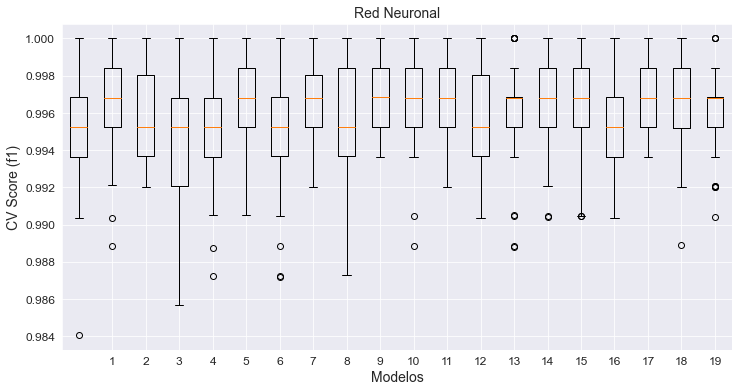


Tiempo de ejecución: 209.85386109352112 segundos


In [22]:
# 2ª etapa

import time
start_time = time.time()

pipe_fs = Pipeline([
#         ('smote_nc', smote_nc), # quitarlo si class_weight='balanced'
        ('feature_selection', SelectKBest(score_func=f_classif)), # k = número de variabs a seleccionar
        ('algorithm', best_model)        
])

parametros_scores = {
    "feature_selection__k": [3,4,5,6],
    "algorithm__hidden_layer_sizes": [3,4,5,6,7], # 1 capa, n-neuronas
}
# "hidden_layer_sizes" también admite varias capas. Por ej:
# [(4,4,2)] es 3 capas con 4, 4 y 2 neuronas respectivamente

# Cambiamos el formato de la malla de parámetros para poder usarlos en el bucle for
grid_params = list(ParameterGrid(parametros_scores)) # lista de diccionarios

cv_scores = []
for params in grid_params:
    # Configura los parámetros del pipeline
    pipe_fs.set_params(**params)
    
        ## set_params permite cambiar los paráms del pipe después de haber sido creado
        ## ** es desempaquetado de diccionarios
        # Es como si estuvieras pasando cada par de clave-valor del diccionario params
        # como un argumento con nombre a la función set_params.
    
    # Calcula las puntuaciones de validación cruzada y las añade a la lista de puntuaciones
    scores = cross_val_score(pipe_fs,
                             X_train_resampled, y_train_resampled, # ojo si SMOTE
                             cv=cv_technique, scoring='f1')
    cv_scores.append(scores)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(cv_scores)
plt.title('Red Neuronal', fontsize=14)
plt.xlabel('Modelos', fontsize=14)
plt.ylabel('CV Score (f1)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(range(2, len(cv_scores)+1), fontsize=12) # no consigo poner el xtick = 0

    # xtick_locs = range(1, len(cv_scores) + 1)
    # xtick_labels = [str(val) for val in parametros_scores["hidden_layer_sizes"]]
    # plt.xticks(xtick_locs, xtick_labels, fontsize=14)
plt.show()

end_time = time.time()
print()
print("Tiempo de ejecución:", end_time - start_time, "segundos")

In [31]:
# Comparar mejores
print(grid_params[0])
print(grid_params[1])
print(grid_params[2])
print(grid_params[3])
print(grid_params[4])
print(grid_params[5])
print(grid_params[6])

{'algorithm__hidden_layer_sizes': 3, 'feature_selection__k': 3}
{'algorithm__hidden_layer_sizes': 3, 'feature_selection__k': 4}
{'algorithm__hidden_layer_sizes': 3, 'feature_selection__k': 5}
{'algorithm__hidden_layer_sizes': 3, 'feature_selection__k': 6}
{'algorithm__hidden_layer_sizes': 4, 'feature_selection__k': 3}
{'algorithm__hidden_layer_sizes': 4, 'feature_selection__k': 4}
{'algorithm__hidden_layer_sizes': 4, 'feature_selection__k': 5}


In [37]:
# El mejor modelo es:
modelo_optimo = 0 # indicar modelo óptimo

print(grid_params[modelo_optimo])

# Configura el pipeline con los parámetros deseados
selected_params = grid_params[modelo_optimo]
pipe_fs.set_params(**selected_params)

# Ajusta el modelo
selected_model = pipe_fs.fit(X_train, y_train)
selected_model

{'algorithm__hidden_layer_sizes': 3, 'feature_selection__k': 3}


Pipeline(steps=[('feature_selection', SelectKBest(k=3)),
                ('algorithm',
                 MLPClassifier(activation='tanh', hidden_layer_sizes=3,
                               random_state=99, solver='lbfgs'))])

In [38]:
selected_model.named_steps['algorithm'].get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 3,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 99,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [39]:
# Variables seleccionadas:

select_names = selected_model.named_steps['feature_selection'].get_feature_names_out()

print(f"Las {len(select_names)} variabs seleccionadas son:")
[i for i in select_names]

Las 3 variabs seleccionadas son:


['scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log',
 'scaler__Est Dia in M(max)_raiz2',
 'scaler__Minimum Orbit Intersection']

El valor de f1 score es: 
 0.99
Otros estadísticos del test: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       787
           1       1.00      0.98      0.99       151

    accuracy                           1.00       938
   macro avg       1.00      0.99      0.99       938
weighted avg       1.00      1.00      1.00       938



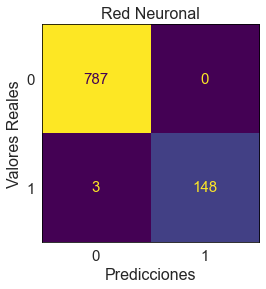

In [40]:
# Evalúa el mejor modelo en tus datos de prueba
y_pred = selected_model.predict(X_test)

# Calcular la precisión de las predicciones en el conjunto de prueba
print(f"El valor de f1 score es: \n {f1_score(y_test, y_pred).round(3)}")
print(f"Otros estadísticos del test: \n {classification_report(y_test, y_pred)}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap='viridis', values_format='d', colorbar=False)
ax.grid(False) # Deshabilitar el grid de fondo

# plt.title('Matriz de confusión', fontsize=18) # Cambiar tamaño del título
ax.spines[['bottom','top','left','right']].set_color('black')
plt.title('Red Neuronal', fontsize=16)
plt.xlabel('Predicciones', fontsize=16)
plt.ylabel('Valores Reales', fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
for text in ax.texts:
    text.set_fontsize(15)
plt.show()

### Importancia de las variabs - Olden Garson

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

net = selected_model

# Calcular la importancia de las variables utilizando el método Olden-Garson
perm = PermutationImportance(net, random_state=seed).fit(X_train, y_train)
feature_names = list(X_train.columns)

# Mostrar los resultados
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.2524 ± 0.0053,scaler__Est Dia in M(max)_raiz2
0.2198 ± 0.0104,scaler__Minimum Orbit Intersection
0.0223 ± 0.0043,scaler__Est Dia in M(max) scaler__Minimum Orbit Intersection_log
0 ± 0.0000,scaler__Est Dia in M(max) scaler__Est Dia in M(max)_raiz2
0 ± 0.0000,scaler__Perihelion Distance scaler__Mean Motion_cuarta
0 ± 0.0000,encoder__Orbit Uncertainity (categ)_1-2


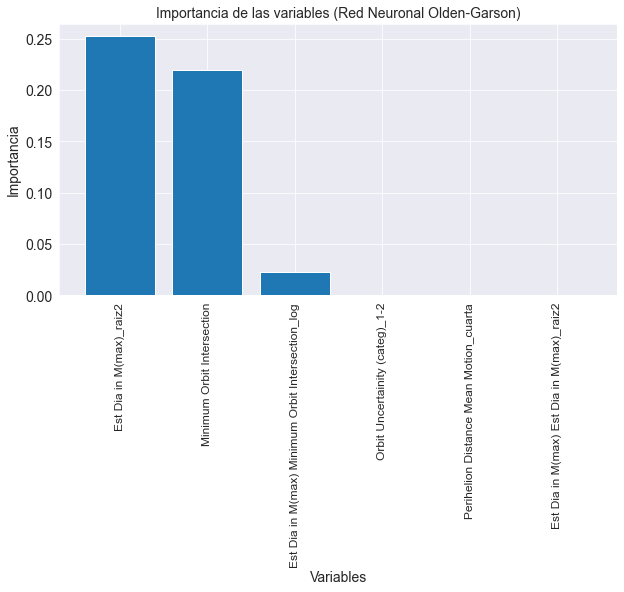

In [29]:
importances = perm.feature_importances_
std = perm.feature_importances_std_

# Crear un dataframe con la información
df_importances = pd.DataFrame({'Variable': feature_names, 'Importancia': importances})

# Ordenar las variables por su importancia
df_importances = df_importances.sort_values('Importancia', ascending=False)

# (recortar el nombre de las variabs, sino es muy largo)
df_importances['Variable'] = df_importances['Variable'].replace(['scaler__', 'encoder__'], '', regex=True)

# Gráfico de barras
plt.figure(figsize=(10,5))
# Como son demasiadas variabs, mostramos solo las n mejores:
n = 10
plt.bar(df_importances['Variable'][0:n], df_importances['Importancia'][0:n])
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=14) 
plt.title('Importancia de las variables (Red Neuronal Olden-Garson)', fontsize=14) 
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Importancia', fontsize=14)
plt.show()


In [41]:
import pickle

# Guarda los datos de puntuaciones
with open('cv_scores_model7.pkl', 'wb') as f:
    pickle.dump(cv_scores[modelo_optimo], f)